In [1]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


sns.set(style="whitegrid")

In [3]:
# Load preprocessed dataset
df = pd.read_csv("../data/preprocessed_data.csv")

# Features and target
X = df.drop("Revenue", axis=1)
y = df["Revenue"].astype(int)

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Positive class ratio (train): {y_train.mean():.3f}")

Train size: (9864, 26), Test size: (2466, 26)
Positive class ratio (train): 0.155


In [4]:
# Build the DNN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the Model with Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.8585 - loss: 0.3673 - val_accuracy: 0.8946 - val_loss: 0.2661
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.8993 - loss: 0.2634 - val_accuracy: 0.8925 - val_loss: 0.2548
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9010 - loss: 0.2482 - val_accuracy: 0.8941 - val_loss: 0.2511
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.9034 - loss: 0.2375 - val_accuracy: 0.8956 - val_loss: 0.2457
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.9034 - loss: 0.2378 - val_accuracy: 0.8956 - val_loss: 0.2424
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9071 - loss: 0.2349 - val_accuracy: 0.8931 - val_loss: 0.2415
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.9072 - loss: 0.2297 - val_accuracy: 0.8966 - val_loss: 0.2412
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9052 - loss: 0

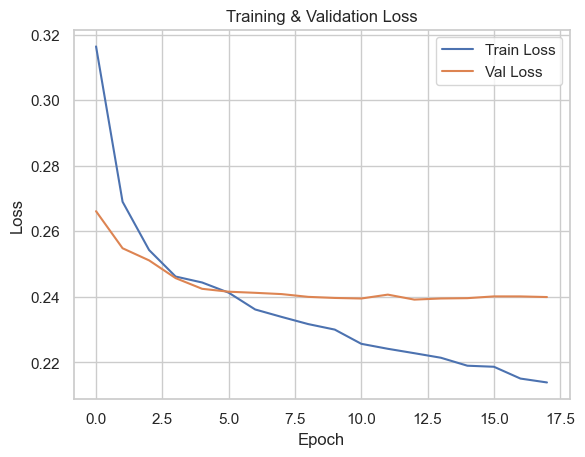

In [6]:
# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
# Evaluate the DNN
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      2084
           1       0.71      0.56      0.63       382

    accuracy                           0.90      2466
   macro avg       0.82      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466

F1 Score: 0.6257309941520468
Precision: 0.7086092715231788
Recall: 0.5602094240837696
ROC AUC: 0.9148159499954779


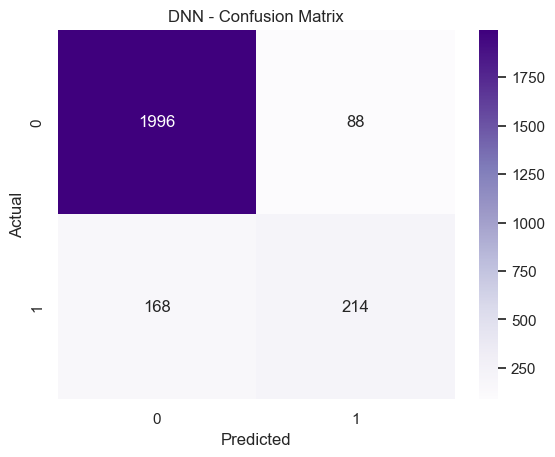

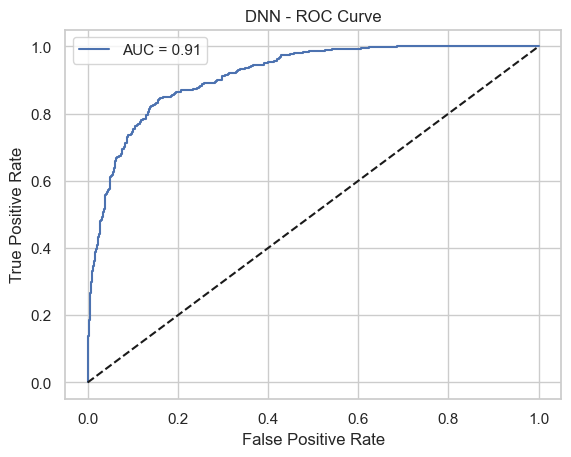

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("DNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DNN - ROC Curve")
plt.legend()
plt.show()

In [9]:
model.save("../models/dnn_model.h5")

In [10]:
# DNN Train/Test comparison
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

def evaluate_dnn_train_test(model, X_train, y_train, X_test, y_test):
    for label, X, y in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_proba = model.predict(X).flatten()
        y_pred = (y_proba >= 0.5).astype(int)

        print(f"🔹 DNN - {label} Set:")
        print(f"   F1 Score     : {f1_score(y, y_pred):.3f}")
        print(f"   Precision    : {precision_score(y, y_pred):.3f}")
        print(f"   Recall       : {recall_score(y, y_pred):.3f}")
        print(f"   ROC AUC      : {roc_auc_score(y, y_proba):.3f}\n")

evaluate_dnn_train_test(model, X_train, y_train, X_test, y_test)

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
🔹 DNN - Train Set:
   F1 Score     : 0.673
   Precision    : 0.752
   Recall       : 0.609
   ROC AUC      : 0.941

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
🔹 DNN - Test Set:
   F1 Score     : 0.626
   Precision    : 0.709
   Recall       : 0.560
   ROC AUC      : 0.915



🔧 Training: 1-layer (64)


/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step

🔧 Training: 2-layer (128,64)


/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step

🔧 Training: 2-layer w/ Dropout


/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step

🔧 Training: 3-layer (128,64,32)


/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step

🔧 Training: 3-layer w/ Dropout


/Users/zhuyanrun/Desktop/cs6140/Project/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


,Model,Train F1,Test F1,Test Precision,Test Recall,Test AUC
2,2-layer w/ Dropout,0.686219,0.643478,0.720779,0.581152,0.918885
4,3-layer w/ Dropout,0.689016,0.639416,0.722772,0.573298,0.916825
0,1-layer (64),0.677125,0.628319,0.719595,0.557592,0.914076
3,"3-layer (128,64,32)",0.681170,0.624071,0.721649,0.549738,0.902736
1,"2-layer (128,64)",0.675009,0.619186,0.696078,0.557592,0.908924


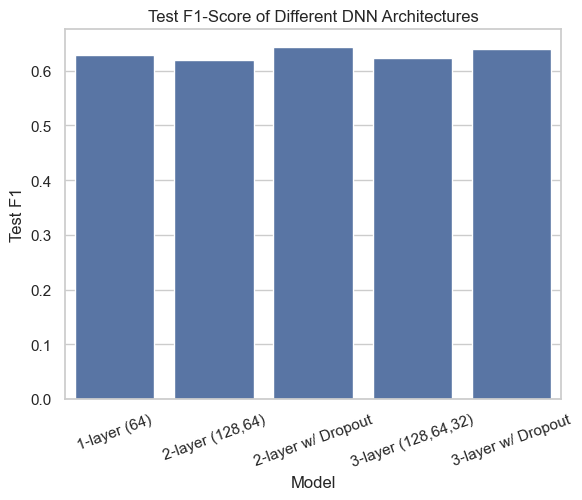

In [11]:
# Define DNN architectures to compare
architectures = [
    {"name": "1-layer (64)",       "layers": [64],         "dropout": False},
    {"name": "2-layer (128,64)",   "layers": [128, 64],    "dropout": False},
    {"name": "2-layer w/ Dropout", "layers": [128, 64],    "dropout": True},
    {"name": "3-layer (128,64,32)","layers": [128, 64, 32],"dropout": False},
    {"name": "3-layer w/ Dropout","layers": [128, 64, 32],"dropout": True},
    
]

results = []

for arch in architectures:
    print(f"\n🔧 Training: {arch['name']}")
    model = Sequential()
    for i, units in enumerate(arch["layers"]):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(Dense(units, activation='relu'))
        if arch["dropout"]:
            model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0  # Change to 1 to show progress
    )

    # Evaluation on train and test sets
    def eval_dnn(name, X, y):
        y_proba = model.predict(X).flatten()
        y_pred = (y_proba >= 0.5).astype(int)
        return {
            "F1": f1_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "AUC": roc_auc_score(y, y_proba),
        }

    train_metrics = eval_dnn("Train", X_train, y_train)
    test_metrics  = eval_dnn("Test",  X_test,  y_test)

    results.append({
        "Model": arch["name"],
        "Train F1": train_metrics["F1"],
        "Test F1":  test_metrics["F1"],
        "Test Precision": test_metrics["Precision"],
        "Test Recall": test_metrics["Recall"],
        "Test AUC": test_metrics["AUC"],
    })

# Display Results
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="Test F1", ascending=False))

sns.barplot(data=results_df, x="Model", y="Test F1")
plt.xticks(rotation=20)
plt.title("Test F1-Score of Different DNN Architectures")
plt.show()